# Lab 03: Pitch Classification

---
author: Jakub Szumny
date: October 2nd, 2024
embed-resources: true
---

## Introduction

A pitch type, is the type of pitch a pitcher in baseball throws. It is possible to infer the pitch type base on only the speed and spin of the ball, as that is what controls the balls movements through the air. Working for Major League Baseball, as a part of the broadcast operations team, I have been tasked with automatically displaying the pitch type for each pitch in real-time. To do this, I will create a classification model that predicts the pitch type of a pitch thrown by a particular pitcher, given the pitch's velocity, rotation, movement, and position of the batter.

## Methods

In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Data

In [28]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)

pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


The data is from a historical pitching dataset which has been provided to me, and the original source of the data is Statcast. Each observation in the data contains information about a single pitch thrown by Shohei Ohtani in 2022, or 2023, during a regular MLB season game. The data is split based on time, the train being the 2022 MLB season, and the test being the 2023 Mlb Season First half. The data contains a response, being the pitch_name, and 5 features, being release_speed, which is measured by the pitches velocity; release_spin_rate, which is measured by the revolutions of the ball per minute; pfx_x which is the horizontal movement in feet of the pitch; pfx_z which is the horizontal movement in feet of the pitch; and stand which is the side of the plate the batter is standing.

In [29]:
# summary statistics
print("Num Samples:", len(pitches_train))
print("Num Features:", len(pitches_train.columns) - 1)

Num Samples: 2628
Num Features: 5


In [30]:
pitches = pitches_train.groupby("pitch_name").size()
print("Counts:", pitches)
print("Proportions:", (pitches/pitches.sum()))

Counts: pitch_name
4-Seam Fastball    718
Curveball          222
Cutter             233
Sinker              97
Slider              63
Split-Finger       312
Sweeper            983
dtype: int64
Proportions: pitch_name
4-Seam Fastball    0.273212
Curveball          0.084475
Cutter             0.088661
Sinker             0.036910
Slider             0.023973
Split-Finger       0.118721
Sweeper            0.374049
dtype: float64


In [31]:
print("Velocity Means:", pitches_train.groupby("pitch_name")["release_speed"].mean())
print("Velocity STDS:", pitches_train.groupby("pitch_name")["release_speed"].std())


Velocity Means: pitch_name
4-Seam Fastball    97.270613
Curveball          77.679730
Cutter             90.742060
Sinker             97.160825
Slider             85.203175
Split-Finger       89.291346
Sweeper            85.336419
Name: release_speed, dtype: float64
Velocity STDS: pitch_name
4-Seam Fastball    1.699270
Curveball          3.215206
Cutter             2.364489
Sinker             1.829592
Slider             2.401543
Split-Finger       1.759299
Sweeper            1.862552
Name: release_speed, dtype: float64


In [32]:
print("Spin Means:", pitches_train.groupby("pitch_name")["release_spin_rate"].mean())
print("Spin STDS:", pitches_train.groupby("pitch_name")["release_spin_rate"].std())

Spin Means: pitch_name
4-Seam Fastball    2217.331933
Curveball          2482.666667
Cutter             2378.424893
Sinker             1972.747368
Slider             2497.619048
Split-Finger       1273.560897
Sweeper            2492.172940
Name: release_spin_rate, dtype: float64
Spin STDS: pitch_name
4-Seam Fastball    114.754683
Curveball          119.854726
Cutter             206.685887
Sinker             143.920632
Slider              78.679306
Split-Finger       221.291146
Sweeper            103.176892
Name: release_spin_rate, dtype: float64


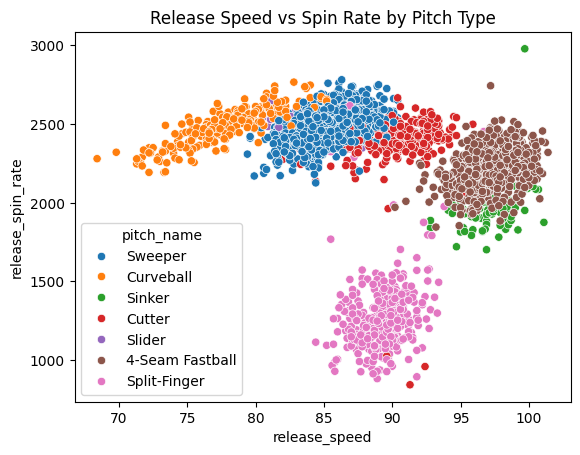

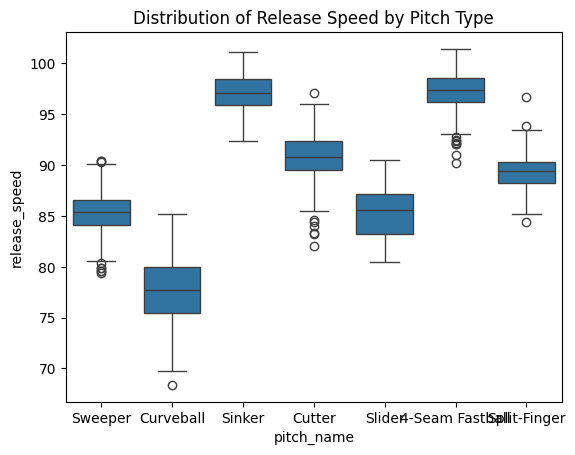

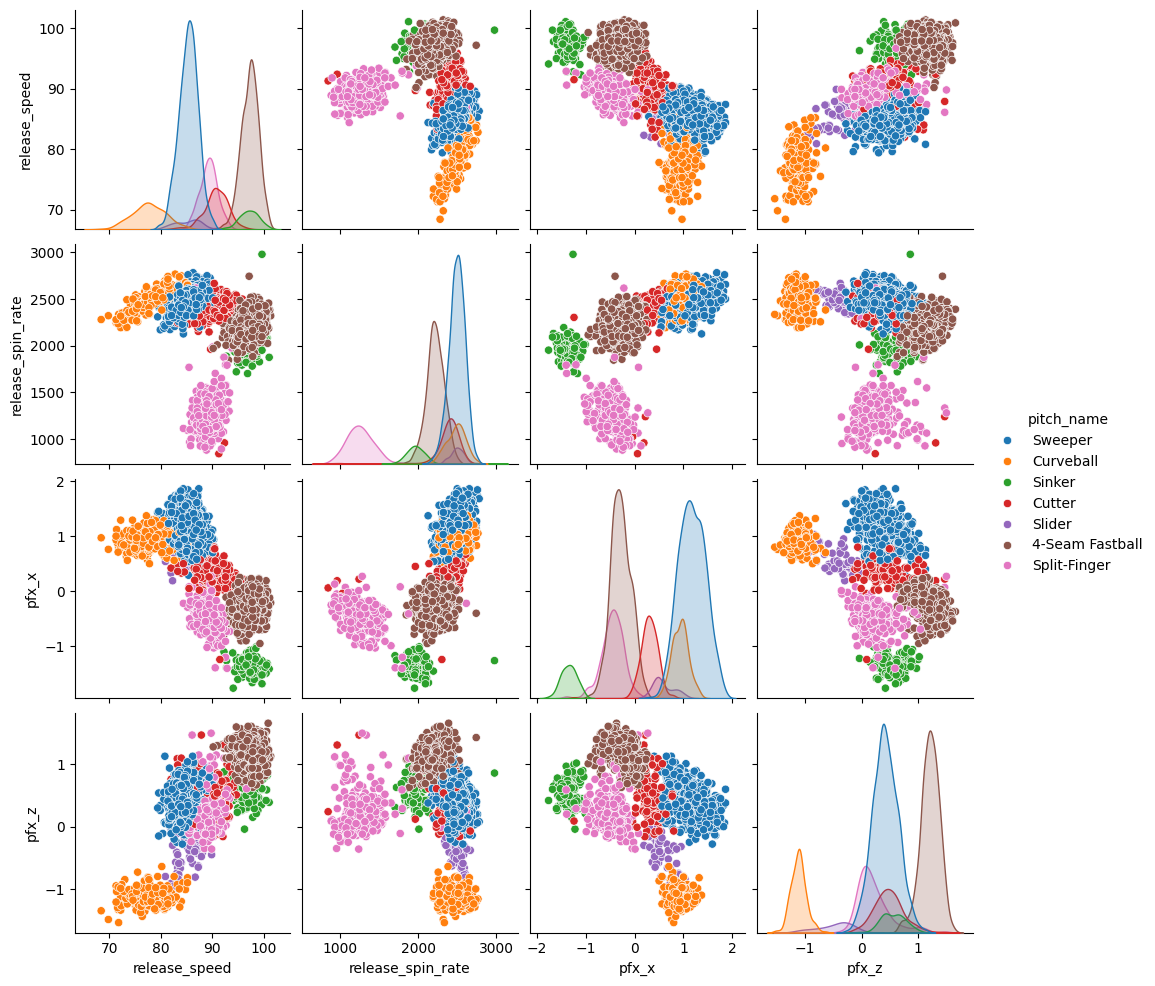

In [33]:
# visualizations
sns.scatterplot(x='release_speed', y='release_spin_rate', hue='pitch_name', data=pitches_train)
plt.title('Release Speed vs Spin Rate by Pitch Type')
plt.show()

sns.boxplot(x='pitch_name', y='release_speed', data=pitches_train)
plt.title('Distribution of Release Speed by Pitch Type')
plt.show()

sns.pairplot(pitches_train, hue='pitch_name', vars=['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'])
plt.show()

Based off of the summary statistics and visualizations, we can see how easily it actually is to determine the type of pitch thrown. Especially in the scatter and pairplot, we can see how distinguished each pitch type is from one another, each having very different release speeds, spin rates, etc.. From the summary statistics we can also see that the velocity and spin means are very distinguishably different, and if paired together they could definitely be a good guess at what type of pitch was thrown. Even just from the distance in the x and z directions that the ball moves from the pitch in feet shows a pretty good distinction on the type of pitches that have been thrown.

### Models

In [34]:
# process data for ML
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [35]:
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


In [36]:
# train models
# note numeric and categorical features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [37]:
# define parameter grid
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__metric": ["euclidean", "manhattan"],
}

# setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")

# run grid search with cross-validation
grid_search.fit(X_train, y_train)

# print best parameters found and best (cross-validated) score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'preprocessor__cat__onehot__drop': None, 'preprocessor__num__scaler': StandardScaler()}
Best cross-validation accuracy: 0.9760195545898969


Here I used a pipeline and a grid search cross validation to find the best parameters for this model, using a KNearestNeighbors Classifier. I found that the best metric to use is manhattan, the best n_neighbors is 9, and a Standard Scaler works best to give us good results. And from this I got a best cross-validation accuracy of .976, which is incredibly good.

In [38]:
best =  grid_search.best_estimator_
y_pred = best.predict(X_test)
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")

from joblib import dump
dump(best, "pitch-classifier.joblib")

Test set accuracy: 0.9358024691358025


['pitch-classifier.joblib']

## Results

In [39]:
# report model metrics
best =  grid_search.best_estimator_
y_pred = best.predict(X_test)
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")

Test set accuracy: 0.9358024691358025


On the test set, the model recieved a .9358 test set accuracy, which is also a really good accuracy for a completely new season of data.

## Discussion

After recieving a test set accuracy of 0.9358, I can say that this model is definitely good, and it could definitely be used for the real life predictions of pitch types. The model definitely still could be refined and made more accurate, but for now with what I have made, I would say it is a very accurate model.

Given that there are hundreds of pitchers in the MLB, and several which are used in a single game, we could probably use a dataset with the data for every pitch by every pitcher in the MLB. This might give us some bias though, as different pitchers use different speeds and spins for similar pitch types. We could also create a bunch of seperate models for each individual pitcher, which wouldn't be too difficult to do as you could create a function and send in different pitchers data, without rewriting all the code. That would definitely give the model much better accuracy than jsut to throw every pitchers data into a single dataset.

Also, using only 2022 for training data, and a part of 2023 as the test data, this does create some potential future issues. Pitchers get better, pitchers get worse, pitchers change up their style, pitchers learn new pitches. All of these factors could potentially lower the models accuracy significantly. The best solution for this issue, would be to update the model yearly, by constantly switching the data to the last two years. This would constantly update each pitchers pitches, and would be much more accurate than to only train one model one time.


### Conclusion

Given the highly accurate performance of this model, I would reccomend this model for usage in real life scenarios. It could definitely still be slightly improved, but not by much, and it gives very good predictions. I would also reccomend to update the model yearly, by constantly training it on the latest data, in order to keep up with current pitchers' pitches. This would guarantee the model keeps its accuracy for years to come.